In [2]:
from torch.utils.data import DataLoader, Dataset
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net18 = models.resnet18(pretrained=True)
resnet18 = nn.Sequential(
    net18.conv1,
    net18.bn1,
    net18.relu,
    net18.maxpool,
    net18.layer1,
    net18.layer2,
    net18.layer3,
    net18.layer4

)


class ResNet18 (nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet18 = resnet18

    def forward(self,x):

        x1 = resnet18[0:5](x)

        x2 = resnet18[5](x1)
        x3 = resnet18[6](x2)
        x4 = resnet18[7](x3)
        avg= nn.AdaptiveAvgPool2d((1,1))
        x1 = avg(x1)
        x2 = avg(x2)
        x3 = avg(x3)
        x4 = avg(x4)
        L = [x1, x2, x3, x4]
        for x in L: 
          print(x.shape)
        L = [xx.squeeze() for xx in L]
        return L




class Adaptation (nn.Module):
    def __init__(self,input):
        super().__init__()
        self.weight_matrix = nn.Linear(input,1024,bias=False)
  


    def forward(self,x):
        x = self.weight_matrix(x)
        x = torch.relu(x)
        
        return x


class Representation(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = ResNet18()

    def forward(self,x1,x2):
        features1 = self.resnet(x1)
        features2= self.resnet(x2)
        features1 = [F.normalize(v) for v in features1]
        features2 = [F.normalize(v) for v in features2]
        return (torch.cat(features1,1),torch.cat(features2,1))

def sim_matrix(a, b, eps=1e-8):
    """
    added eps for numerical stability
    """
    a_n, b_n = a.norm(dim=1)[:, None], b.norm(dim=1)[:, None]
    a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
    b_norm = b / torch.max(b_n, eps * torch.ones_like(b_n))
    sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))
    return sim_mt


**Fonction de calcul de la loss**

---



In [3]:
def calc_loss(left,right,temp):
  sim1 = sim_matrix(left, right)
  sim2 = sim1.t()
  loss_left2right= F.cross_entropy(sim1* temp, torch.arange(len(sim1)).long().to(device)).to(device)
  loss_right2left= F.cross_entropy(sim2* temp, torch.arange(len(sim2)).long().to(device)).to(device)
  loss = loss_left2right* 0.5 + loss_right2left * 0.5
  return loss

**Accuracy**

In [4]:
def accuracy (left,right,K):
  correct = 0
  sim = sim_matrix(left, right)
  for i in range(len(left)):
    val,j = torch.topk(sim[i],K)
    for pos in range(k):
      if i==j[pos].item():
        correct += 1
  return correct

**Calcul top K**

In [5]:
def get_topK(left,right,k):
  correct = 0
  sim = sim_matrix(left, right)
  
  sim2 = sim.t()
  for i in range(len(left)):
    val,j = torch.topk(sim[i],k,sorted=True)
    val2, j2 = torch.topk(sim2[i],k,sorted=True)

    for pos in range(k):
      if j[pos].item()==i | j2[pos].item()==i:
        
        correct += 1
  return correct



**Seconde manière pour avoir le topk** 
Les résultats obtenus sont différents 

In [18]:
def get_topk2(left,right, k):
  sim = sim_matrix(left, right)
  
  sorted_idx = sim.argsort(0)
  
 
  sens1 = np.array([lbl in sorted_idx[lbl][:k] for lbl in range(len(left))])    
  sim = sim.t()
  sorted_idx = sim.argsort(0)
  sens2 = np.array([lbl in sorted_idx[lbl][:k] for lbl in range(len(left))])

  return ((sens1 | sens2).mean())

In [7]:
""" Load emmbidings """

data = np.load("pairs_ebds.npy", allow_pickle=True).reshape(-1)[0]


In [31]:
left = data['left_ebds']
right = data['right_ebds']

Train avec zero_grad()

In [26]:
def train1(left_train, right_train, left_tst, right_tst,epochs,adaptation, optimizer,k,temp):

   
    score =0
    recall = []
    recall2=[]
    left_train = torch.from_numpy(left_train).type(torch.FloatTensor).to(device)
    right_train = torch.from_numpy(right_train).type(torch.FloatTensor).to(device)
    left_tst = torch.from_numpy(left_tst).type(torch.FloatTensor).to(device)
    right_tst = torch.from_numpy(right_tst).type(torch.FloatTensor).to(device)
    
    train_losses =[]
    test_losses=[]
    total_train = len(left_train)
    total_test = len(left_tst)
    for epoch in tqdm(range(epochs)):

  
        adaptation.train()
        running_loss =0.0
        optimizer.zero_grad()
        left_adapted = adaptation(left_train)
        right_adapted = adaptation(right_train)
        loss = calc_loss(left_adapted,right_adapted,temp)
        loss.backward()
        optimizer.step()
        running_loss +=loss.item()    
        with torch.no_grad():
          adaptation.eval()
          test_loss=0.0
          left_adapted_test = adaptation(left_tst)
          right_adapted_test = adaptation(right_tst)
          loss = calc_loss(left_adapted_test,right_adapted_test,temp)
          test_loss += loss.item()

        score = get_topK(left_adapted_test,right_adapted_test,k)
        recall.append(score/total_test)
        recall2.append(get_topk2(left_adapted_test,right_adapted_test,k))
        train_losses.append(running_loss)
        test_losses.append(test_loss)
        print("Epoch " , (epoch+1))
        print("Train Loss: ",running_loss)
        print("Test Loss: ",test_loss)
        print("Recall :", recall[epoch])
        print("Recall 2 :", recall2[epoch])
        
    print(sum(recall)/len(recall))
    plt.plot(train_losses, label='Training loss')
    plt.plot(test_losses, label='Testing loss')
    plt.legend()
    plt.show()
    plt.figure(1)
    plt.plot(recall,label ='Recall' )
    plt.plot(recall2,label ='Recall 2' )
    plt.legend()
    plt.show


Train en accumulant le gradient

In [9]:
def train2(left_train, right_train, left_tst, right_tst,epochs,adaptation, optimizer,k,temp):

   
    score =0
    recall = []
    left_train = torch.from_numpy(left_train).type(torch.FloatTensor).to(device)
    right_train = torch.from_numpy(right_train).type(torch.FloatTensor).to(device)
    left_tst = torch.from_numpy(left_tst).type(torch.FloatTensor).to(device)
    right_tst = torch.from_numpy(right_tst).type(torch.FloatTensor).to(device)
    
    train_losses =[]
    test_losses=[]
    total_train = len(left_train)
    total_test = len(left_tst)
    for epoch in tqdm(range(epochs)):

  
        adaptation.train()
        running_loss =0.0
        #optimizer.zero_grad()
        left_adapted = adaptation(left_train)
        right_adapted = adaptation(right_train)
        loss = calc_loss(left_adapted,right_adapted,temp)
        loss.backward()
        optimizer.step()
        running_loss +=loss.item()    
        with torch.no_grad():
          adaptation.eval()
          test_loss=0.0
          left_adapted_test = adaptation(left_tst)
          right_adapted_test = adaptation(right_tst)
          loss = calc_loss(left_adapted_test,right_adapted_test,temp)
          test_loss += loss.item()

        score = get_topK(left_adapted_test,right_adapted_test,k)
        recall.append(score/total_test)
        train_losses.append(running_loss)
        test_losses.append(test_loss)
        print("Epoch " , (epoch+1))
        print("Train Loss: ",running_loss)
        print("Test Loss: ",test_loss)
        print("Recall :", recall[epoch])
        
    print(sum(recall)/len(recall))
    plt.plot(train_losses, label='Training loss')
    plt.plot(test_losses, label='Testing loss')
    plt.legend()
    plt.show()
    plt.figure(1)
    plt.plot(recall,label ='Recall' )
    plt.legend()
    plt.show

In [39]:
def run(runs,left,right,epochs, k,temp,type,spl):

  """
  runs : number of experiments 
  left, right : embeddings
  epochs : number of epochs 
  k : aR@k
  temp : temperature
  type : gradient accumulation =>2 
          else => 1 
  spl : train size
  """
  for i in range(runs):

    
    N = len(left)
    sample = int(spl*N)
    idx = np.random.permutation(data['left_ebds'].shape[0])  
    train_idx, test_idx = idx[:sample], idx[sample:]

    model = Adaptation(512)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(),lr =0.0005,weight_decay=1e-5)



    left_train, left_test, right_train, right_test = left[train_idx,:], left[test_idx,:], right[train_idx,], right[test_idx,]
    if type==1:
      train1(left_train,right_train,left_test, right_test,epochs, model, optimizer,k,temp)
    else:
      train2(left_train,right_train,left_test, right_test,epochs, model, optimizer,k,temp) 






**Sans PCA**

Epoch  1
Train Loss:  7.222549915313721
Test Loss:  6.003381729125977
Recall : 0.06571428571428571
Recall 2 : 0.0
Epoch  2
Train Loss:  7.067775726318359
Test Loss:  5.877322673797607
Recall : 0.07047619047619047
Recall 2 : 0.0009523809523809524
Epoch  3
Train Loss:  6.91226863861084
Test Loss:  5.755480766296387
Recall : 0.07523809523809524
Recall 2 : 0.0038095238095238095
Epoch  4
Train Loss:  6.75992488861084
Test Loss:  5.640798091888428
Recall : 0.08285714285714285
Recall 2 : 0.0019047619047619048
Epoch  5
Train Loss:  6.61368465423584
Test Loss:  5.535353660583496
Recall : 0.08571428571428572
Recall 2 : 0.0019047619047619048
Epoch  6
Train Loss:  6.4751434326171875
Test Loss:  5.440179824829102
Recall : 0.08761904761904762
Recall 2 : 0.0009523809523809524
Epoch  7
Train Loss:  6.3439764976501465
Test Loss:  5.353849411010742
Recall : 0.08857142857142856
Recall 2 : 0.0
Epoch  8
Train Loss:  6.219182014465332
Test Loss:  5.275289535522461
Recall : 0.08952380952380952
Recall 2 : 0.0

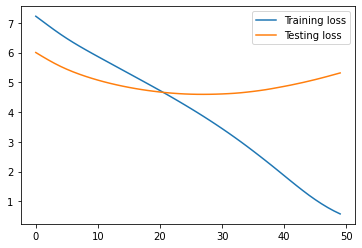

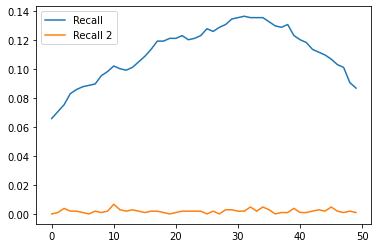

In [32]:
run(1,left,right,50,1,15,1,0.75)

Epoch  1
Train Loss:  7.259979724884033
Test Loss:  5.873608589172363
Recall : 0.05952380952380952
Epoch  2
Train Loss:  7.104369163513184
Test Loss:  5.756792068481445
Recall : 0.060714285714285714
Epoch  3
Train Loss:  6.95497989654541
Test Loss:  5.647398948669434
Recall : 0.060714285714285714
Epoch  4
Train Loss:  6.8125200271606445
Test Loss:  5.547236442565918
Recall : 0.06904761904761905
Epoch  5
Train Loss:  6.679264068603516
Test Loss:  5.457736968994141
Recall : 0.07142857142857142
Epoch  6
Train Loss:  6.556947231292725
Test Loss:  5.379575729370117
Recall : 0.07023809523809524
Epoch  7
Train Loss:  6.445943832397461
Test Loss:  5.311843395233154
Recall : 0.07261904761904762
Epoch  8
Train Loss:  6.345621109008789
Test Loss:  5.253657817840576
Recall : 0.07142857142857142
Epoch  9
Train Loss:  6.254611015319824
Test Loss:  5.2030439376831055
Recall : 0.075
Epoch  10
Train Loss:  6.170891284942627
Test Loss:  5.157900810241699
Recall : 0.07380952380952381
Epoch  11
Train Loss

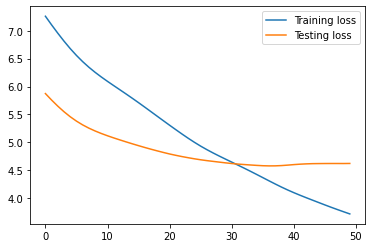

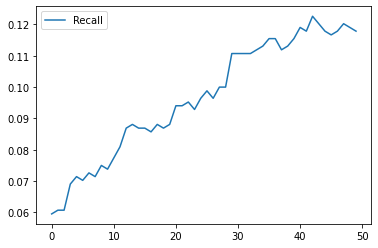

In [34]:
run(1,left,right,50,1,15,2,0.8)

**En accumulant le gradient**

Epoch  1
Train Loss:  7.198492050170898
Test Loss:  5.988706588745117
Recall : 0.07238095238095238
Epoch  2
Train Loss:  7.04074764251709
Test Loss:  5.863842964172363
Recall : 0.07714285714285714
Epoch  3
Train Loss:  6.890432834625244
Test Loss:  5.747666358947754
Recall : 0.07904761904761905
Epoch  4
Train Loss:  6.749134063720703
Test Loss:  5.642317771911621
Recall : 0.08476190476190476
Epoch  5
Train Loss:  6.619372844696045
Test Loss:  5.548861980438232
Recall : 0.08857142857142856
Epoch  6
Train Loss:  6.502353668212891
Test Loss:  5.466495037078857
Recall : 0.08857142857142856
Epoch  7
Train Loss:  6.397591590881348
Test Loss:  5.39422607421875
Recall : 0.09142857142857143
Epoch  8
Train Loss:  6.303265571594238
Test Loss:  5.330283164978027
Recall : 0.09333333333333334
Epoch  9
Train Loss:  6.216968059539795
Test Loss:  5.272355556488037
Recall : 0.09619047619047619
Epoch  10
Train Loss:  6.136203289031982
Test Loss:  5.218920707702637
Recall : 0.0980952380952381
Epoch  11
Tr

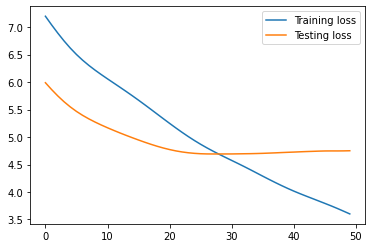

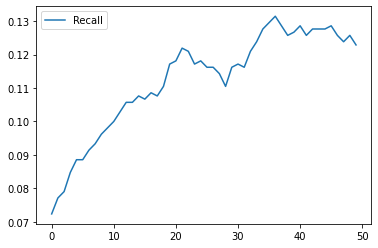

In [12]:
run(1,50,1,15,2,0.75)

In [35]:
from sklearn.decomposition import PCA
pca = PCA(512).fit((left))
left_reduced = pca.transform(left)
pca = PCA(512).fit((right))
right_reduced = pca.transform(right)

Epoch  1
Train Loss:  8.062366485595703
Test Loss:  6.905645370483398
Recall : 0.0009523809523809524
Recall 2 : 0.0019047619047619048
Epoch  2
Train Loss:  7.948101997375488
Test Loss:  6.861378192901611
Recall : 0.0009523809523809524
Recall 2 : 0.0009523809523809524
Epoch  3
Train Loss:  7.83535099029541
Test Loss:  6.818121433258057
Recall : 0.0009523809523809524
Recall 2 : 0.002857142857142857
Epoch  4
Train Loss:  7.724206924438477
Test Loss:  6.775967597961426
Recall : 0.0009523809523809524
Recall 2 : 0.0019047619047619048
Epoch  5
Train Loss:  7.614756107330322
Test Loss:  6.734953880310059
Recall : 0.0009523809523809524
Recall 2 : 0.0019047619047619048
Epoch  6
Train Loss:  7.507108211517334
Test Loss:  6.695096969604492
Recall : 0.0009523809523809524
Recall 2 : 0.0009523809523809524
Epoch  7
Train Loss:  7.40130615234375
Test Loss:  6.656314849853516
Recall : 0.0009523809523809524
Recall 2 : 0.0038095238095238095
Epoch  8
Train Loss:  7.297370910644531
Test Loss:  6.61860847473

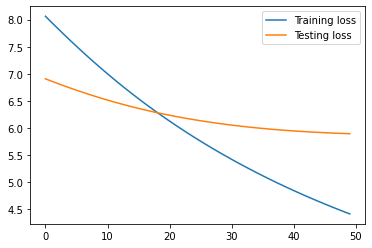

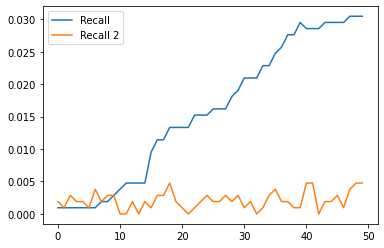

In [37]:
run(1,left_reduced,right_reduced,50,1,15,1,0.75)

Epoch  1
Train Loss:  8.072441101074219
Test Loss:  6.967750549316406
Recall : 0.0009523809523809524
Epoch  2
Train Loss:  7.958558082580566
Test Loss:  6.922571659088135
Recall : 0.0019047619047619048
Epoch  3
Train Loss:  7.8500165939331055
Test Loss:  6.878630638122559
Recall : 0.0019047619047619048
Epoch  4
Train Loss:  7.7438130378723145
Test Loss:  6.835555076599121
Recall : 0.0009523809523809524
Epoch  5
Train Loss:  7.639019012451172
Test Loss:  6.793240070343018
Recall : 0.0019047619047619048
Epoch  6
Train Loss:  7.535309791564941
Test Loss:  6.751691818237305
Recall : 0.0019047619047619048
Epoch  7
Train Loss:  7.432651519775391
Test Loss:  6.710948944091797
Recall : 0.002857142857142857
Epoch  8
Train Loss:  7.331110954284668
Test Loss:  6.671030044555664
Recall : 0.002857142857142857
Epoch  9
Train Loss:  7.230795860290527
Test Loss:  6.631927490234375
Recall : 0.0038095238095238095
Epoch  10
Train Loss:  7.131826877593994
Test Loss:  6.59367561340332
Recall : 0.0057142857

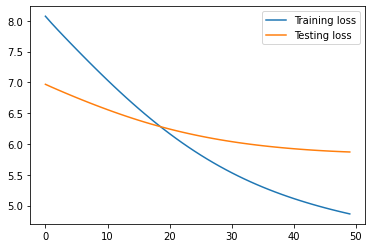

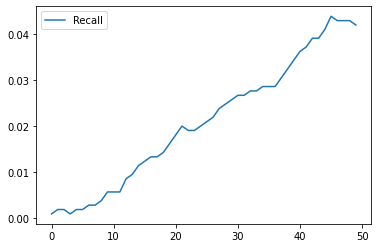

In [38]:
run(1,left_reduced,right_reduced,50,1,15,2,0.75)